In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
code.global_options()

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.QeCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True}

In [ ]:
# RunRules for m100
nodes = 1
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PrExIn',
                memory='120GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.QeCalculator(rr)
code.global_options()

# DFT analysis of the Stanene monolayer

This notebook contains the DFT analysis of the 2D Stanene monolayer performed with QuantumESPRESSO.

We make usage of ONCV pseudopotential (without NLCC) which is fully compatible with Yambo

## Lattice properties and atomic positions

We use the lattice configuration adopted by QuantumESPRESSO in the ibrav=4 case.

The basis vector of the (direct) lattice are defined as
$$
a_1 = a_{lat}(1,0,0) \, ,\quad a_2 = a_{lat}(\frac{-1}{2},\frac{\sqrt{3}}{2},0) \, ,\quad
a_3 = a_{lat}(0,0,\frac{c}{a_{lat}})
$$
so that $c$ vacuum space between two replica of the sheets, expressed in the same units as $a_{lat}$.
We also observe that $\textrm{celldm(3)}=c/a_{lat}$, so it expresses the vacuum distance in terms of 
$a_{lat}$.

The cartesian component of the reciprocal lattice vectors (in units of $2\pi/a_{alat}$) are given by:

$$
b_1 = (1,\frac{1}{\sqrt{3}}) \, ,\quad b_2 = (0,\frac{2}{\sqrt{3}},0) \, ,\quad
b_3 = (0,0,\frac{a}{c})
$$
The reciprocal vectors have module $2/\sqrt{3}$.

The cartesian coordinates of the high symmetry points of the reciprocal lattice (in units of $2\pi/a_{alat}$) 
can be determined by performing the construction of the Brillouin zone: we find the points on at the half of
the $b_1$ and $b_2$ vectors and build the path moving perpendicularly to the basis vector directions.
The $M$ point (at the middle of the hexagon face) and the $K$ point (the edge point) are given by:
$$
M = (\frac{1}{2},\frac{1}{2\sqrt{3}}) \, \quad
K = (\frac{2}{3},0) 
$$
Moreover we write the coordinates of the symmetry related K' point (which corresponds to another edge of the hexagon)
and M' point (middle point of the top edge of the hexagon): 
$$
K' = (\frac{1}{3},\frac{1}{\sqrt{3}}) \, \quad
M' = (0,\frac{1}{\sqrt{3}}) 
$$
These points, together with $\Gamma$ define the IBZ edges in the representation of QuantumESPRESSO.

In cartesian coordinates the atomic positions read
$$
Sn_1 = a_{lat}(0,\frac{1}{\sqrt{3}},\delta) \, \qquad Sn_2 = a_{lat}(\frac{1}{2},\frac{1}{2\sqrt{3}},-\delta)
$$
where $\delta$ is the buckling of the Sn atoms in units of $a_{lat}$.

## GS Analysis

We analyze the electronic configuration of the GS.

We use the converged configuration achieved with the PAW pseudo as starting 
point for the analysis with the ONCV one.

In [4]:
run_dir = 'DFT_analysis-ONCV'
pseudo_dir = '../pseudos'
Sn_pseudo = 'Sn_ONCV_PBE_FR-1.1.upf'

alat_0 =  8.83641018 # in a.u. (Bohr)
delta_0 = 0.09148726 # in units of alat
c_0 = 25.0 # vacuum distance in a.u. 

ecut_0 = 80 # energy cutoff on the wavefunction (Ry)
kpoints_0 = [15,15,1]

Sn1 = np.array([0,1./np.sqrt(3.),delta_0])
Sn2 = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_0])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(30)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Sn',pseudo_name=Sn_pseudo,mass=118.71)
inp.set_atoms_number(2)
inp.set_atomic_positions([['Sn',Sn1],['Sn',Sn2]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_0,celldm3=c_0/alat_0)
inp.set_energy_cutoff(ecut_0)
inp.set_kpoints(type='automatic',points=kpoints_0)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 8.83641018,
  'celldm(3)': 2.8292032047792515,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Sn': [118.71, 'Sn_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Sn', array([0.        , 0.57735027, 0.09148726])],
   ['Sn', array([ 0.5       ,  0.28867513, -0.09148726])]]},
 'kpoints': {'type': 'automatic', 'values': ([15, 15, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

Then we perform the convergence analysis on the various parameters.

### Calculation of the equilibrium lattice constants and buckling parameter

We determine the equiblrium values of the lattice constant and of the buckling parameter by minimizing
the GS energy.

In this case we converge the alat and delta parameters one by one

In [15]:
alat_span = np.linspace(-3,1,5) #7
alat_span

array([-3., -2., -1.,  0.,  1.])

In [25]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)

for a_span in alat_span:
    a = alat_0*(1+a_span/100)
    idd = {'alat' : a_span}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_lattice(ibrav=4,celldm1=a,celldm3=c_0/a)
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)

Initialize a Dataset with 2 parallel tasks


In [26]:
study.ids

[{'alat': -3.0}, {'alat': -2.0}, {'alat': -1.0}, {'alat': 0.0}, {'alat': 1.0}]

In [18]:
#study.runs[2]

In [27]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1], [2, 3], [4]] 

Run the task [0, 1] 
create the run_dir folder : 'DFT_analysis-ONCV'
run command: mpirun -np 16 pw.x -inp alat_-3.0.in > alat_-3.0.log
run command: mpirun -np 16 pw.x -inp alat_-2.0.in > alat_-2.0.log
slurm submit:  slurm submit: cd DFT_analysis-ONCV ; sbatch job_alat_-3.0.sh 
cd DFT_analysis-ONCV ; sbatch job_alat_-2.0.sh
computation alat_-3.0 is running...
computation alat_-2.0 is running...
computation alat_-3.0 ended
computation alat_-2.0 ended
Task [0, 1] ended 
 
Run the task [2, 3] 
run command: mpirun -np 16 pw.x -inp alat_-1.0.in > alat_-1.0.log
run command: mpirun -np 16 pw.x -inp alat_0.0.in > alat_0.0.logslurm submit: 
 cd DFT_analysis-ONCV ; sbatch job_alat_-1.0.shslurm submit: 
 cd DFT_analysis-ONCV ; sbatch job_alat_0.0.sh
computation alat_-1.0 is running...
computation alat_0.0 is running...
computation alat_-1.0 ended
computation alat_0.0 ended
Task [2, 3] ended 
 
Run the task [4] 

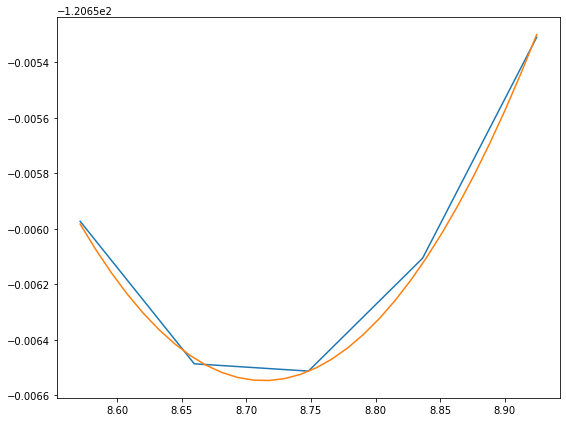

In [28]:
plt.figure(figsize=(9,7))
y = [results[ind] for ind in range(len(study.ids))]
x = [alat_0*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [29]:
alat_conv = -coeffs[1]/(2*coeffs[0])
alat_conv

8.71345991080035

Then we perform a convergence on delta using the alat_conv as lattice constant

In [31]:
delta_span = np.linspace(-2,1,4)
delta_span

array([-2., -1.,  0.,  1.])

In [33]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)

inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c_0/alat_conv)
for d_span in delta_span:
    d = delta_0*(1+d_span/100)    
    Sn1 = np.array([0,1./np.sqrt(3.),d])
    Sn2 = np.array([1./2.,1./(2*np.sqrt(3.)),-d])
    idd = {'delta' : d_span}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_atomic_positions([['Sn',Sn1],['Sn',Sn2]],type='alat')
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)

Initialize a Dataset with 2 parallel tasks


In [35]:
study.ids

[{'delta': -2.0}, {'delta': -1.0}, {'delta': 0.0}, {'delta': 1.0}]

In [41]:
#study.runs[2]

In [42]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0, 1], [2, 3]] 

Run the task [0, 1] 
run command: mpirun -np 16 pw.x -inp delta_-2.0.in > delta_-2.0.log
slurm submit: run command: mpirun -np 16 pw.x -inp delta_-1.0.in > delta_-1.0.log 
cd DFT_analysis-ONCV ; sbatch job_delta_-2.0.sh
slurm submit:  cd DFT_analysis-ONCV ; sbatch job_delta_-1.0.sh
computation delta_-2.0 is running...
computation delta_-1.0 is running...
computation delta_-2.0 ended
computation delta_-1.0 ended
Task [0, 1] ended 
 
Run the task [2, 3] 
run command: mpirun -np 16 pw.x -inp delta_0.0.in > delta_0.0.log
run command: mpirun -np 16 pw.x -inp delta_1.0.in > delta_1.0.logslurm submit: 
 cd DFT_analysis-ONCV ; sbatch job_delta_0.0.shslurm submit: 
 cd DFT_analysis-ONCV ; sbatch job_delta_1.0.sh
computation delta_0.0 is running...
computation delta_1.0 is running...
computation delta_0.0 ended
computation delta_1.0 ended
Task [2, 3] ended 
 


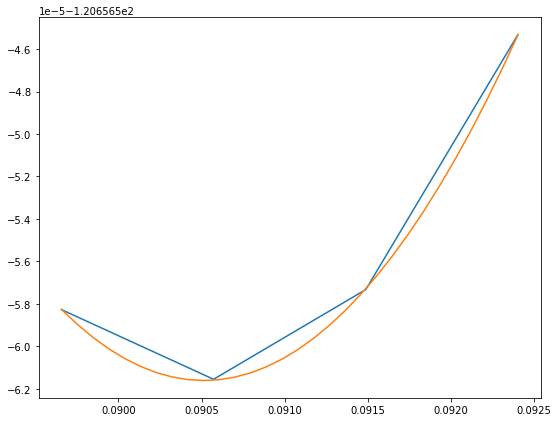

In [43]:
plt.figure(figsize=(9,7))
y = [results[ind] for ind in range(len(study.ids))]
x = [delta_0*(1+d/100) for d in delta_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [44]:
delta_conv = -coeffs[1]/(2*coeffs[0])
delta_conv

0.09051433200277159

Lastly, we perform a further convergence on alat to check the alat_conv value
is preserved by the modified value of delta

In [45]:
alat_span = np.linspace(-2,2,5) #7
alat_span

array([-2., -1.,  0.,  1.,  2.])

In [47]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)

Sn1 = np.array([0,1./np.sqrt(3.),delta_conv])
Sn2 = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])
inp.set_atomic_positions([['Sn',Sn1],['Sn',Sn2]],type='alat')

for a_span in alat_span:
    a = alat_conv*(1+a_span/100)
    idd = {'alat' : a_span,'delta':'converged'}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_lattice(ibrav=4,celldm1=a,celldm3=c_0/a)
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)

Initialize a Dataset with 2 parallel tasks


In [48]:
study.ids

[{'alat': -2.0, 'delta': 'converged'},
 {'alat': -1.0, 'delta': 'converged'},
 {'alat': 0.0, 'delta': 'converged'},
 {'alat': 1.0, 'delta': 'converged'},
 {'alat': 2.0, 'delta': 'converged'}]

In [51]:
#study.runs[1]

In [52]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1], [2, 3], [4]] 

Run the task [0, 1] 
run command: mpirun -np 16 pw.x -inp alat_-2.0-delta_converged.in > alat_-2.0-delta_converged.log
slurm submit:  run command: mpirun -np 16 pw.x -inp alat_-1.0-delta_converged.in > alat_-1.0-delta_converged.logcd DFT_analysis-ONCV ; sbatch job_alat_-2.0-delta_converged.sh

slurm submit:  cd DFT_analysis-ONCV ; sbatch job_alat_-1.0-delta_converged.sh
computation alat_-2.0-delta_converged is running...
computation alat_-1.0-delta_converged is running...
computation alat_-1.0-delta_converged ended
computation alat_-2.0-delta_converged ended
Task [0, 1] ended 
 
Run the task [2, 3] 
run command: mpirun -np 16 pw.x -inp alat_0.0-delta_converged.in > alat_0.0-delta_converged.log
run command: mpirun -np 16 pw.x -inp alat_1.0-delta_converged.in > alat_1.0-delta_converged.logslurm submit: 
 cd DFT_analysis-ONCV ; sbatch job_alat_0.0-delta_converged.shslurm submit: 
 cd DFT_analysis-ONCV 

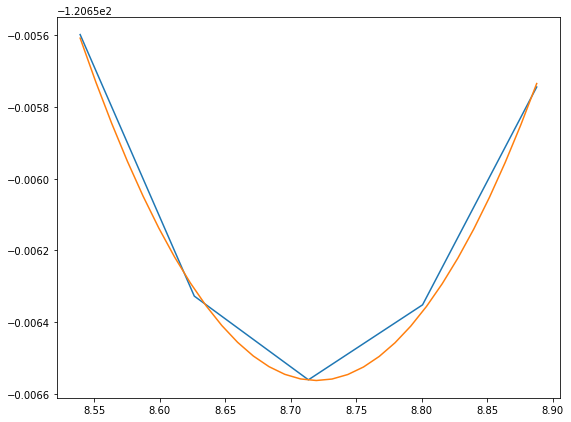

In [53]:
plt.figure(figsize=(9,7))
y = [results[ind] for ind in range(len(study.ids))]
x = [alat_conv*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [54]:
alat_conv_new = -coeffs[1]/(2*coeffs[0])
alat_conv,alat_conv_new

(8.71345991080035, 8.719659878539446)

We observe that the alat_conv is stable within the second digit so we consider the
convergence process completed.

Finally we set

In [5]:
alat_conv = 8.71966
delta_conv = 0.090514

Sn1 = np.array([0,1./np.sqrt(3.),delta_conv])
Sn2 = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])
inp.set_atomic_positions([['Sn',Sn1],['Sn',Sn2]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c_0/alat_conv)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 8.71966,
  'celldm(3)': 2.86708426704711,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Sn': [118.71, 'Sn_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Sn', array([0.        , 0.57735027, 0.090514  ])],
   ['Sn', array([ 0.5       ,  0.28867513, -0.090514  ])]]},
 'kpoints': {'type': 'automatic', 'values': ([15, 15, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

We can express these parameters in Angstrom and compare the results with the value reported in the
paper Progress in Surface Science 96 (2021) 100615 of Olivia and Fredhelm

In [79]:
alat_conv*U.Constants.Bohr_to_Angstrom

4.6142456910153395

In [82]:
delta_conv*alat_conv*U.Constants.Bohr_to_Angstrom*2

0.8353076689531248

to be compared with alat = 4.67-4.68 and Delta = 0.85, so we find that the reticular parameters are a little bit
smaller with this pseudo.

### Convergence procedure on the $k$-points sampling and of energy cutoff of the wave functions

We perform a set of calculations in functions of the number of k-points and of the energy cutoff and we find
the converged values using the total ground state energy, the gap at $K$ and the gap at $\Gamma$ as control quantities.

In [17]:
kvalues = [12,15,18,21]
ecut = [60,80,100,120]

In [18]:
study = D.Dataset(run_dir=run_dir,num_tasks=3)

for k in kvalues:
    for e in ecut:
        idd = {'ecut' : e, 'k' : k}
        inp.set_prefix(D.name_from_id(idd))
        inp.set_kpoints(type='automatic',points=[k,k,1])
        inp.set_energy_cutoff(e)
        study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 3 parallel tasks


In [19]:
study.ids

[{'ecut': 60, 'k': 12},
 {'ecut': 80, 'k': 12},
 {'ecut': 100, 'k': 12},
 {'ecut': 120, 'k': 12},
 {'ecut': 60, 'k': 15},
 {'ecut': 80, 'k': 15},
 {'ecut': 100, 'k': 15},
 {'ecut': 120, 'k': 15},
 {'ecut': 60, 'k': 18},
 {'ecut': 80, 'k': 18},
 {'ecut': 100, 'k': 18},
 {'ecut': 120, 'k': 18},
 {'ecut': 60, 'k': 21},
 {'ecut': 80, 'k': 21},
 {'ecut': 100, 'k': 21},
 {'ecut': 120, 'k': 21}]

In [21]:
#study.runs[4]

In [23]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] with the parallel task_groups [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11], [12, 13, 14], [15]] 

Run the task [0, 1, 2] 
Skip the run of Skip the run ofecut_60-k_12
 ecut_80-k_12
Skip the run of ecut_100-k_12
Task [0, 1, 2] ended 
 
Run the task [3, 4, 5] 
Skip the run of ecut_120-k_12Skip the run of
 ecut_60-k_15
Skip the run of ecut_80-k_15
Task [3, 4, 5] ended 
 
Run the task [6, 7, 8] 
Skip the run ofSkip the run of ecut_100-k_15 
ecut_120-k_15
Skip the run of ecut_60-k_18
Task [6, 7, 8] ended 
 
Run the task [9, 10, 11] 
Skip the run of ecut_80-k_18Skip the run of
 ecut_100-k_18Skip the run of
 ecut_120-k_18
Task [9, 10, 11] ended 
 
Run the task [12, 13, 14] 
Skip the run of ecut_60-k_21Skip the run of
 ecut_80-k_21
Skip the run of ecut_100-k_21
Task [12, 13, 14] ended 
 
Run the task [15] 
Skip the run of ecut_120-k_21
Task [15] ended 
 


12 [-120.6565146234047, -120.656514109171, -120.6565173547135, -120.6565145404025]
15 [-120.6565611716314, -120.6565606545469, -120.6565638955805, -120.6565610838148]
18 [-120.6565781884668, -120.6565776639298, -120.656580910506, -120.6565780958944]
21 [-120.6565854849979, -120.6565849615944, -120.6565882076015, -120.6565853951737]


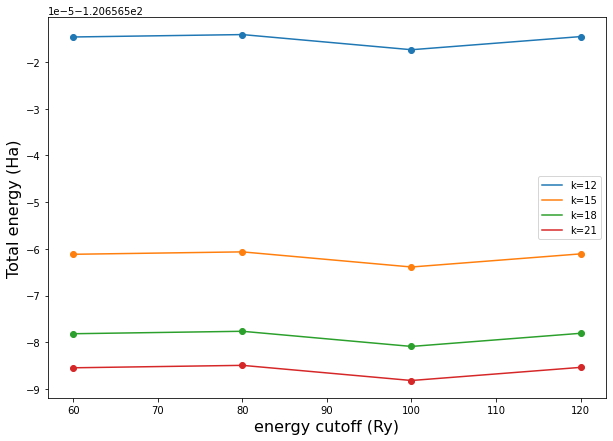

In [24]:
plt.figure(figsize=(10,7))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
for k in kvalues:
    energy =study.fetch_results(id={'k':k},attribute='energy')
    print(k,energy)
    plt.plot(ecut,energy,label='k=%s'%k)
    plt.scatter(ecut,energy)
#plt.ylim(-120.8,-120.6)
plt.legend()

12 [0.08837909694438206, 0.08837710759779238, 0.08837825783706443, 0.08838062931302548]
15 [0.08838956571738832, 0.08838578895719862, 0.08838928538715202, 0.08838719983095317]
18 [0.08839042816226006, 0.08838888515921245, 0.08839034400553908, 0.08838917218873105]
21 [0.08839168476259118, 0.08838972607547341, 0.08839108645138644, 0.0883900735239263]
12 [0.4505429566585739, 0.45065206184930673, 0.4506134645239973, 0.450624092176689]
15 [0.45079617692355345, 0.450878154762925, 0.4508564697692564, 0.45088103487747444]
18 [0.4509034494468013, 0.4510237728583584, 0.45095894914441104, 0.45098495007885353]
21 [0.4509419943251425, 0.45106080737246795, 0.4510350475354191, 0.45103523655582434]


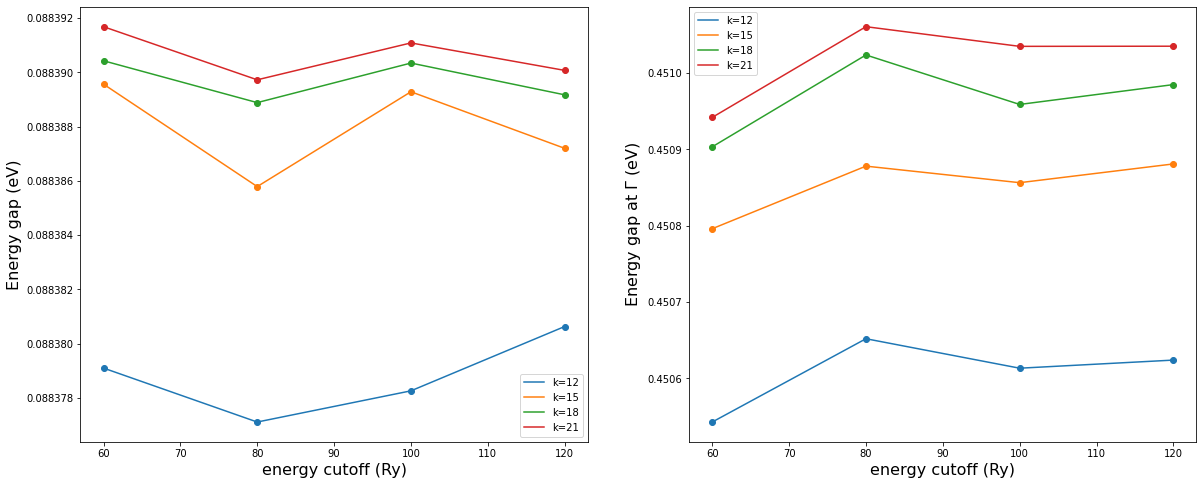

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 8))

ax[0].set_xlabel('energy cutoff (Ry)',size=16)
ax[0].set_ylabel('Energy gap (eV)',size=16)
for k in kvalues:
    data = study.fetch_results(id={'k':k})    
    gap = [d.get_gap(verbose=False)['direct_gap'] for d in data]
    print(k,gap)
    ax[0].plot(ecut,gap,label='k=%s'%k)
    ax[0].scatter(ecut,gap)
ax[0].legend()
ax[1].set_xlabel('energy cutoff (Ry)',size=16)
ax[1].set_ylabel('Energy gap at $\Gamma$ (eV)',size=16)
for k in kvalues:
    data = study.fetch_results(id={'k':k})    
    gap_gamma = [d.get_evals()[0][28]- d.get_evals()[0][27] for d in data]
    print(k,gap_gamma)
    ax[1].plot(ecut,gap_gamma,label='k=%s'%k)
    ax[1].scatter(ecut,gap_gamma)
ax[1].legend()

On the basis of these results we choose

In [38]:
ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [15,15,1]

In [39]:
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)

### Convergence analysis on the spacing between the sheets replica

We perform a convergence study on the vacuum distance parameter.

In [41]:
c_values = [5,10,15,20,25,30] # in a.u.
#Sn1 = np.array([0,1./np.sqrt(3.),delta_conv])
#Sn2 = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

study = D.Dataset(run_dir=run_dir,num_tasks=3)

for cval in c_values:
    idd = {'vacuum_value' : cval}
    inp.set_prefix(D.name_from_id(idd))
    #inp.set_atomic_positions([['Sn',Sn1],['Sn',Sn2]],type='alat')
    inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=cval/alat_conv)
    study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 3 parallel tasks


In [45]:
#study.runs[2]

In [46]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0, 1, 2], [3, 4, 5]] 

Run the task [0, 1, 2] 
delete job_out script: DFT_analysis-ONCV/job_vacuum_value_5.outdelete job_out script:
 DFT_analysis-ONCV/job_vacuum_value_10.outdelete job_out script:
 DFT_analysis-ONCV/job_vacuum_value_15.out
delete log file: DFT_analysis-ONCV/vacuum_value_5.logdelete log file:
 delete log file:DFT_analysis-ONCV/vacuum_value_10.log 
DFT_analysis-ONCV/vacuum_value_15.log
delete xml file: /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/Xenes/Stanene/DFT_analysis-ONCV/vacuum_value_5.xml
delete xml file: delete xml file:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/Xenes/Stanene/DFT_analysis-ONCV/vacuum_value_10.xml 
/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/Xenes/Stanene/DFT_analysis-ONCV/vacuum_value_15.xml
delete folder: /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/Xenes/Stanene/DFT_analysis-ONCV/vacuum_value_5.save
delete folder: delete folder:/work/dalessandro/2D

[-121.0100060482556, -120.6284463528808, -120.6549670082163, -120.6565017284884, -120.6565606545469, -120.6565615370741]


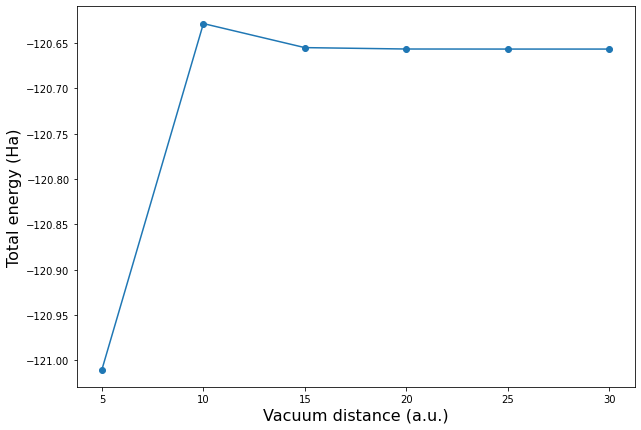

In [47]:
plt.figure(figsize=(10,7))
plt.xlabel('Vacuum distance (a.u.)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
energy = [r.energy for r in results.values()]
plt.plot(c_values,energy)
plt.scatter(c_values,energy)
print(energy)

[0.25720399154436535, 0.096695454411865, 0.08885459004827201, 0.0884029439099529, 0.08838578895719862, 0.08838569054395573]
[3.782638819375384, 0.6580565592291405, 0.46777593803943285, 0.45239153653968656, 0.450878154762925, 0.45076244019491996]


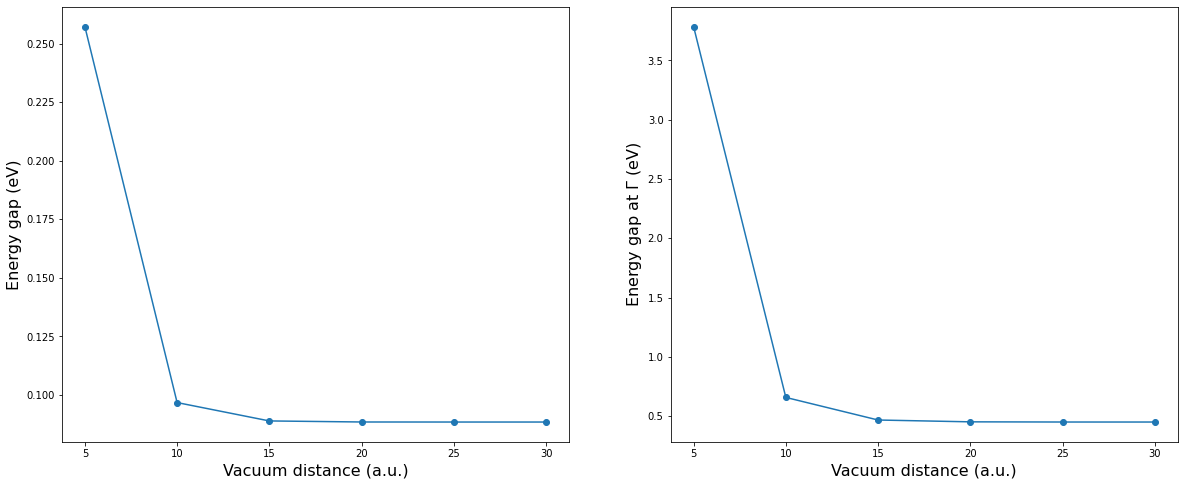

In [48]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 8))

ax[0].set_xlabel('Vacuum distance (a.u.)',size=16)
ax[0].set_ylabel('Energy gap (eV)',size=16)
gap = [r.get_gap(verbose=False)['direct_gap'] for r in results.values()]
ax[0].plot(c_values,gap)
ax[0].scatter(c_values,gap)
print(gap)
ax[1].set_xlabel('Vacuum distance (a.u.)',size=16)
ax[1].set_ylabel('Energy gap at $\Gamma$ (eV)',size=16)
gap_gamma = [r.get_evals()[0][28]- r.get_evals()[0][27] for r in results.values()]
ax[1].plot(c_values,gap_gamma)
ax[1].scatter(c_values,gap_gamma)
print(gap_gamma)

On the basis of this analysis we choose c = 25 a.u. as the converged vacuum spacing

### Converged ground states

Finally we perform a last scf calculation with converged parameters

In [103]:
run_dir = 'DFT_analysis-ONCV'
pseudo_dir = '../pseudos'
Sn_pseudo = 'Sn_ONCV_PBE_FR-1.1.upf'

alat_conv = 8.71966 # in a.u. (Bohr)
delta_conv = 0.090514 # in units of alat
c_conv = 25.0 # vacuum distance in a.u. 

ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [15,15,1]

Sn1 = np.array([0,1./np.sqrt(3.),delta_conv])
Sn2 = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(30)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Sn',pseudo_name=Sn_pseudo,mass=118.71)
inp.set_atoms_number(2)
inp.set_atomic_positions([['Sn',Sn1],['Sn',Sn2]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c_conv/alat_conv)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 8.71966,
  'celldm(3)': 2.86708426704711,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Sn': [118.71, 'Sn_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Sn', array([0.        , 0.57735027, 0.090514  ])],
   ['Sn', array([ 0.5       ,  0.28867513, -0.090514  ])]]},
 'kpoints': {'type': 'automatic', 'values': ([15, 15, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [104]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [105]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of gs_converged
Task [0] ended 
 


In [107]:
results[0].get_gap()

Direct gap system
Gap : 0.08838578895719862 eV


{'gap': 0.08838578895719862,
 'direct_gap': 0.08838578895719862,
 'position_cbm': 26,
 'positon_vbm': 26,
 'positon_direct_gap': 26}

Gap at $\Gamma$

In [108]:
results[0].get_evals()[0][28]- results[0].get_evals()[0][27]

0.450878154762925

## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [63]:
bands_prefix = 'bands'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [64]:
klist = Tools.build_pw_kpath(G,Mp,Kp,G,numstep=30)
klist

[[0.0, 0.0, 0.0, 30],
 [0.0, 0.5773502691896258, 0.0, 30],
 [0.3333333333333333, 0.5773502691896258, 0.0, 30],
 [0.0, 0.0, 0.0, 0]]

In [65]:
inp.set_bands(32,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 32,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 8.71966,
  'celldm(3)': 2.86708426704711,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Sn': [118.71, 'Sn_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Sn', array([0.        , 0.57735027, 0.090514  ])],
   ['Sn', array([ 0.5       ,  0.28867513, -0.090514  ])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 30],
   [0.0, 0.5773502691896258, 0.0, 30],
   [0.3333333333333333, 0.5773502691896258, 0.0, 30],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [66]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis-ONCV/gs_converged.save')

copy source_dir DFT_analysis-ONCV/gs_converged.save in the /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/Xenes/Stanene/DFT_analysis-ONCV/bands.save
run command: mpirun -np 16 pw.x -inp bands.in > bands.log
slurm submit:  cd DFT_analysis-ONCV ; sbatch job_bands.sh
computation bands is running...
computation bands ended


Once that the computation is over we can create an instance of PwBands

In [68]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [69]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.5773502657018026, 0.9106835999999987, 0.57735027])

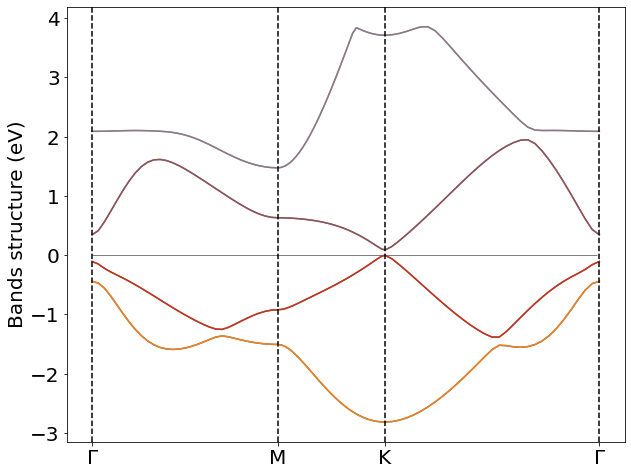

In [70]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(24,32)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

## NSCF computations on regular grids

We set up the nscf computations on regular grids.

In [50]:
Gamma = np.array([0.,0.])
K = np.array([2./3.,0])
M = np.array([1./2.,1./(2*np.sqrt(3))])
Kp = np.array([1./3.,1./np.sqrt(3)])
Mp = np.array([0.,1./np.sqrt(3)])

In [70]:
nbnds = 500 #30
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'prefix': "'kpoints_72-nbnds_30'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 500,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 8.71966,
  'celldm(3)': 2.86708426704711,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Sn': [118.71, 'Sn_ONCV_PBE_FR-1.1.upf']},
 'atomic_positions': {'type': 'alat',
  'values': [['Sn', array([0.        , 0.57735027, 0.090514  ])],
   ['Sn', array([ 0.5       ,  0.28867513, -0.090514  ])]]},
 'kpoints': {'type': 'automatic', 'values': ([72, 72, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [71]:
kvalues = [18] #[18,30,42,60,72]

In [72]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kvalues:
    idd = {'kpoints':k,'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,1])
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis-ONCV/gs_converged.save')

Initialize a Dataset with 2 parallel tasks


In [74]:
#study.runs[0]

In [ ]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
copy source_dir DFT_analysis-ONCV/gs_converged.save in the /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/Xenes/Stanene/DFT_analysis-ONCV/kpoints_18-nbnds_500.save
run command: mpirun -np 16 pw.x -inp kpoints_18-nbnds_500.in > kpoints_18-nbnds_500.log
slurm submit:  cd DFT_analysis-ONCV ; sbatch job_kpoints_18-nbnds_500.sh
computation kpoints_18-nbnds_500 is running...


In [62]:
results[0].get_gap()

Direct gap system
Gap : 0.08838303683896637 eV


{'gap': 0.08838303683896637,
 'direct_gap': 0.08838303683896637,
 'position_cbm': 36,
 'positon_vbm': 36,
 'positon_direct_gap': 36}

In [68]:
kp = results[4].kpoints # cartesian coordinates in units of 2\pi/alat

number of kpoints = 469


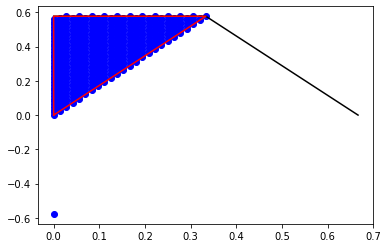

In [69]:
BZ = [K, Kp, Mp]
print('number of kpoints = %s'%len(kp))
plt.plot(*np.column_stack(BZ),color='black')
IBZ = [Gamma,Kp, Mp,Gamma]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')